In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

In [2]:
%config InlineBackend.figure_format = 'retina'

#### Estimating a Population Proportion with Confidence

In [3]:
# sample size
n = 659

# number of people saying yes
x = 540

# best estimate
p_hat = x / n

# margin of error
moe = 1.96 * np.sqrt((p_hat * (1 - p_hat)) / n)

p_hat - moe, p_hat + moe

(0.7900537499137914, 0.8487929875672404)

In [4]:
sm.stats.proportion_confint(x, n)

(0.7900542895874294, 0.8487924478936024)

#### Estimating a Population Mean with Confidence

In [5]:
df = pd.read_csv('data/cartwheel_data.csv')

In [6]:
t = 2.064

# necessary values
n = len(df)
mean = df['CWDistance'].mean()
sd = df['CWDistance'].std()

moe = t * (sd / np.sqrt(n))
mean - moe, mean + moe

(76.26382957453707, 88.69617042546294)

In [7]:
sm.stats.DescrStatsW(df['CWDistance']).zconfint_mean()

(76.57715593233024, 88.38284406766977)

A simple random sample of 500 undergraduates at a large university self-administered a political knowledge test, where the maximum score is 100 and the minimum score is 0. The mean score was 62.5, and the standard deviation of the scores was 10. What is a 95% confidence interval for the overall undergraduate mean at the university?

**!!!Caution** In this case, we have a standard deviation from sampling. So, we need estimated standard deviation to calculating to confidence interval for the overall. We can calculate the estimated standard deviation as follows,

\begin{equation*}ESD = \frac{SD}{\sqrt{n}}\end{equation*}

- SD: Standard deviation
- ESD: Estimated standard deviation for the overall

In [8]:
n = 500
mean = 62.5
sd = 10

# estimated standard deviation
esd = sd / np.sqrt(n)

upper = mean + 1.96 * esd
lower = mean - 1.96 * esd

lower, upper

(61.62346135282008, 63.37653864717992)

#### Confidence intervals case study using NHANES data

In [9]:
df = pd.read_csv('data/NHANES.csv')

##### Confidence intervals for one proportion

We will calculate the proportions of smokers separately for females and for males.  Initially we can compare these two proportions and their corresponding confidence intervals informally, but later we will discuss methods to compare two proportions formally using confidence intervals.

First we replace the numeric codes in the variables of interest with text labels, and set the rare answers other than "yes" and "no" to be missing (so they will automatically be omitted from all the analyses below).

In [10]:
mapping = {
    1: 'Yes', 
    2: 'No', 
    7: np.nan, 
    9: np.nan
}

gender_map = {
    1: 'Male',
    2: 'Female'
}

df['SMQ020x'] = df.SMQ020.replace(mapping)
df['RIAGENDRx'] = df.RIAGENDR.replace(gender_map)

We can now [tabulate](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html) the numbers of female and male smokers and non-smokers:

In [11]:
dx = df[['SMQ020x', 'RIAGENDRx']].dropna()
pd.crosstab(dx.SMQ020x, dx.RIAGENDRx)

RIAGENDRx,Female,Male
SMQ020x,,
No,2066,1340
Yes,906,1413


The confidence interval (CI) is constructed using two inputs: the sample proportion of smokers, and the total sample size for smokers and non-smokers combined.  We calculate these values next.

In [12]:
dz = dx \
    .groupby(dx.RIAGENDRx) \
    .agg({'SMQ020x': [lambda x: np.mean(x == 'Yes'), np.size]})

dz.columns = ['Proportion', 'Total_n']
dz

,Proportion,Total_n
RIAGENDRx,,
Female,0.304845,2972
Male,0.513258,2753


Confidence intervals are closely connected to standard errors.  Recall that the standard error essentially tells you how
far you should expect an estimate to fall from the truth.  A confidence interval is an interval that under repeated sampling covers the truth a defined proportion of the time.  In most settings, this "coverage probability" is set to 95%.  

It turns out that in many settings, a 95% confidence interval can be constructed as the interval consisting of all points that are within two (or 1.96) standard errors of the point estimate.  More concisely, the confidence interval approximately spans from e - 2•SE to e + 2•SE, where e is the point estimate and SE is the standard error.

Since the standard error plays such an important role here, we calculate it separately first.

In [13]:
p = dz.Proportion.Female
n = dz.Total_n.Female

se_female = np.sqrt(p * (1 - p) / n)
print(se_female)

p = dz.Proportion.Male
n = dz.Total_n.Male

se_male = np.sqrt(p * (1 - p) / n)
print(se_male)

0.008444152146214435
0.009526078653689868


We can see that the standard errors for the estimated proportions of females and males who smoke are similar, and are each around 1% (since we are studying a proportion here, 0.01 corresponds to a 1 percentage point change in the smoking rate).  

The standard error for a proportion is maximized when the true proportion is around 1/2, and gets smaller as the true proportion approaches either 0 or 1.  The estimated male smoking proportion is closer to 1/2 than the estimated female smoking proportion, and the male sample size is smaller than the female sample size.  Both of these factors lead to the male standard error being larger than the female standard error, although the difference is very small in this case.

Next we calculate the 95% confidence intervals for the proportions of female and male smokers using the formula for the one-sample confidence interval for a proportion:

In [14]:
p = dz.Proportion.Female 
n = dz.Total_n.Female

lcb = p - 1.96 * se_female
ucb = p + 1.96 * se_female

lcb, ucb

(0.288294683866098, 0.32139576027925865)

In [15]:
p = dz.Proportion.Male 
n = dz.Total_n.Male

lcb = p - 1.96 * se_male
ucb = p + 1.96 * se_male

lcb, ucb

(0.49458714955108174, 0.531929377873546)

These results indicate that any population proportion (for male lifetime smokers) between 0.493 and 0.531 would be compatible with the NHANES data.

In a routine data analysis, we do not need to calculate these intervals manually.  We can use the Statsmodels library to calculate the CI for us in one line:

In [16]:
sm.stats.proportion_confint(906, 906 + 2066)

(0.2882949879861214, 0.32139545615923526)

In [17]:
sm.stats.proportion_confint(1413, 1413 + 1340)

(0.49458749263718593, 0.5319290347874418)

##### Confidence intervals comparing two independent proportions

The confidence intervals for the proportions of female and male smokers shown above are quite narrow and do not overlap.  This suggests that there is a substantial difference between the lifetime smoking rates for women and men. However there is no explicit information here about how different the two population proportions might be.  To address this question, we can form a confidence interval for the difference between the proportion of females who smoke and the proportion of males who smoke.  

The point estimate of the difference between female and male smoking rates is -0.208 (0.305 - 0.513).  That is, the smoking rate is about 20 percentage points higher in men than in women.  This difference of around 20 percentage points is only a point estimate of the underlying true value -- it is not exactly equal to the difference between the unknown proportions of females and males who smoke in the population.  A confidence interval helps us assess how far the estimated difference may be from the true difference.

As above, we start with the standard error.  The difference between two sample proportions based on independent data has a standard error that reflects the combined uncertainty in the two proportions being differenced.  This standard error can be calculated very easily.  If SE1 and SE2 are the standard errors for two proportions, then sqrt(SE1^2 + SE2^2) is the standard error for the difference of these proportions (`sqrt` is the square root function).  Note that this formula is only accurate if the two sample proportions being differenced are independent.

In the next cell we calculate the standard error for the difference between the proprotion of females who smoke and the proportion of males who smoke.

In [18]:
se_diff = np.sqrt(se_female ** 2 + se_male ** 2)
se_diff

0.012729881381407434

The standard error of around 0.013 indicates that the estimated difference statistic -0.208 is expected to fall around 0.013 units from the true value.  We do not know in which direction the error lies, and we do not know that the error is exactly 0.013, only that it is around this large on average.  For most purposes, a standard error of 0.013 relative to an observed difference of -0.21 would be considered very small.  That is, we have a very accurate estimate of the difference between smoking rates in women and in men.

Now that we have the standard error, we can construct a 95% confidence interval for the difference in proportions by taking the estimate and subtracting and adding two (or 1.96) standard errors from it.

In [19]:
d = dz.Proportion.Female - dz.Proportion.Male
lcb = d - 2 * se_diff
ucb = d + 2 * se_diff
lcb, ucb

(-0.2338728044024504, -0.18295327887682067)

The 95% confidence interval above shows us that any value for the difference of population proportions (between females and males) lying between -0.233 and -0.183 is consistent with the observed data.

##### Confidence intervals for subpopulations

Since smoking rates vary strongly with age, it might be more informative to stratify the data into homogeneous age bands and compare the proportions of female and male smokers within each age band.  We can also calculate the 95% confidence interval for this difference within each age band.  These data can be displayed as a plot, with the difference in proportions plotted as a curve.  The confidence intervals can then be used to construct a "confidence band" around the estimates.

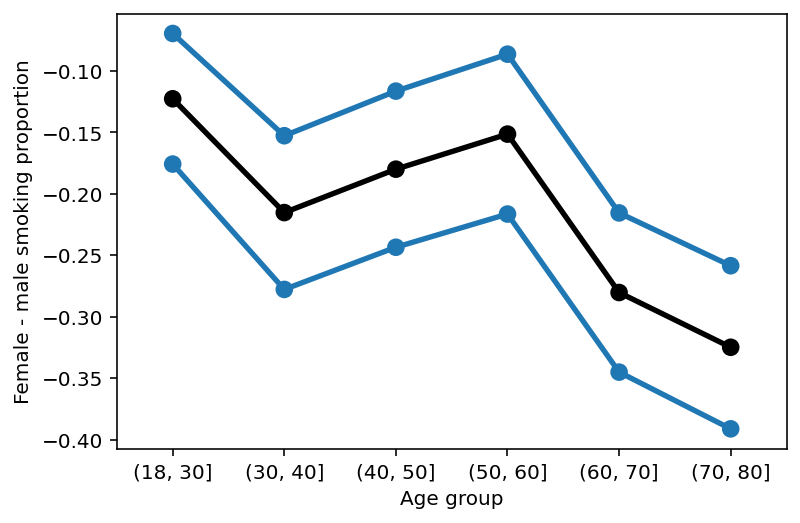

In [20]:
# calculate the smoking rates within age/gender groups
df['agegrp'] = pd.cut(df.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
pr = df \
    .groupby(['agegrp', 'RIAGENDRx']) \
    .agg({'SMQ020x': lambda x: np.mean(x == 'Yes')}) \
    .unstack()
pr.columns = ['Female', 'Male']

# the number of people for each calculated proportion
dn = df \
    .groupby(['agegrp', 'RIAGENDRx']) \
    .agg({'SMQ020x': np.size}).unstack()
dn.columns = ['Female', 'Male']

# standard errors for each proportion
se = np.sqrt(pr * (1 - pr) / dn)

# standard error for the difference in female/male smoking rates in every age band
se_diff = np.sqrt(se.Female ** 2 + se.Male ** 2)

# the difference in smoking rates between genders
pq = pr.Female - pr.Male

x = np.arange(pq.size)

pp = sns.pointplot(x, pq.values, color='black')
sns.pointplot(x, pq - 2 * se_diff)
sns.pointplot(x, pq + 2 * se_diff)

pp.set_xticklabels(pq.index)
pp.set_xlabel('Age group')
pp.set_ylabel('Female - male smoking proportion');

The plot above shows for each age band, the point estimate of the difference in smoking rates between genders (black dot), and the lower and upper end points of the 95% confidence interval (blue points).  Based on this plot, we see that in the United States, smoking is more common in men than in women, not just overall, but also in every one of the age bands.  The difference is largest for older people -- for people older than 60, the smoking rate for males is around 30 percentage points greater than the smoking rate for females, while for people younger than 30, the smoking rate for males is only around 15 percentage points greater than the smoking rate for females.

Also note that the 95% confidence bands shown above are much wider than the 95% confidence intervals for the data that were not stratified by age.  Stratifying by age leads to smaller sample sizes, which in turn results in wider confidence intervals.

##### Confidence intervals for the mean

In this section, we discuss how to construct confidence intervals for the mean.  First note that the proportion discussed above is also a mean -- for example, if the data are 0, 1, 0, then the mean is 1/3, which is also the proportion of 1's in the data.  However the proportion has the special property that the variance is completely determined by the mean. That is why we constructed the standard errors for the sample proportion above using p•(1 - p) as the variance.  In general, the variance of quantitative data will not be a function of the mean, as this is a very special property of binary data.  Therefore, in general we must estimate the variance as a separate step after estimating the mean. 

To illustrate the construction of confidence intervals for the population mean of a quantitative variable, we will use the body mass inde (BMI) data from NHANES.  To begin, we calculate the mean BMI for all women and for all men in the NHANES sample.

In [21]:
df.groupby('RIAGENDRx').agg({'BMXBMI': np.mean})

,BMXBMI
RIAGENDRx,
Female,29.939946
Male,28.778072


The numbers in the first column of the table above are estimates of the population mean BMI for all women and for all men in the United States (the population that the NHANES study represents). As with the sample proportions, these numbers are not exactly equal to the mean BMI for all women and men, they are only estimates.  To establish the uncertainty for these estimates, we can use the standard errors for these two estimated means.

The standard error for the mean based on an independent and identically distributed sample is equal to the standard deviation of the variable divided by the square root of the sample size.  We next calculate all the relevant values needed to compute the standard error. 

In [22]:
df.groupby('RIAGENDRx').agg({'BMXBMI': [np.mean, np.std, np.size]})

BMXBMI                  
                mean       std    size
RIAGENDRx                             
Female     29.939946  7.753319  2976.0
Male       28.778072  6.252568  2759.0

We can now calculate the standard error of the mean BMI for women and for men:

In [23]:
sem_female = 7.753 / np.sqrt(2976)
sem_male = 6.253 / np.sqrt(2759)
sem_female, sem_male

(0.14211938534506902, 0.119045388988243)

We see that the sample mean BMI for women is expected to be off by around 0.14 relative to the population mean BMI for women, and the sample mean BMI for men is expected to be off by around 0.12 relative to the population mean BMI for men.

The standard error of the mean for women is slightly larger for women than for men.  The reason for this is that even though the NHANES sample size for women is slightly larger than that for men, the data for women appears to be more spread out.  The greater standard deviation for the female BMI values leads in turn to less precision when estimating the population mean BMI for females. 

As was the case for proportions, the 95% confidence interval for the mean can be calculated by taking the estimate plus and minus 2 (or 1.96) times the standard error.  The 95% confidence interval for female BMI is thus calculated as follows:

In [24]:
lcb_female = 29.94 - 1.96 * 7.753 / np.sqrt(2976)
ucb_female = 29.94 + 1.96 * 7.753 / np.sqrt(2976)
lcb_female, ucb_female

(29.661446004723665, 30.218553995276338)

In [25]:
female_bmi = df.loc[df.RIAGENDRx == 'Female', 'BMXBMI'].dropna()
sm.stats.DescrStatsW(female_bmi).zconfint_mean()

(29.659875498090155, 30.22001580625768)

##### Confidence intervals for the difference between two means

Now we turn to studying the difference between two means, taking the difference between mean female and male BMI for illustration.  As discussed above, the standard error for the difference of two means taken from independent samples is sqrt(SE1^2 + SE2^2), where SE1 and SE2 are the standard errors for the two means being compared.  Below we see that this gives us a value around 0.19 when comparing the female BMI to the male BMI.  This is substantially larger than either the SEM for estimating the female mean (0.14) or the SEM for estimating the male mean (0.12).  It is expected that the standard error for the difference between two means is greater than the standard errors for estimating a single mean, since the uncertainty of both gender-specific proportions impacts the statistic.

In [26]:
sem_diff = np.sqrt(sem_female ** 2 + sem_male ** 2)
sem_diff

0.18539073420811059

In [27]:
bmi_diff = 29.94 - 28.78
lcb = bmi_diff - 2 * sem_diff
ucb = bmi_diff + 2 * sem_diff
lcb, ucb

(0.789218531583779, 1.5307814684162213)

This finding indicates that while the point estimate shows that the women in our sample have around 1.1 unit greater BMI than the men in our sample, the true difference between the mean for all women in the population and for all men in the population could fall between 0.79 and 1.53, and still be consistent with the observed data.

**Age-stratified confidence intervals** As a final example, we refine the analysis above by considering the difference of mean BMI values between females and males within age bands.  We see below that the overall average difference of 1.1 units results from differences that are very different based on age.  Specifically, the difference between female and male BMI is much smaller than 1.1 for younger people, and much larger than 1.1 for older people.  

Since the confidence bands for people under 40 contain 0, the data are consistent with there being no difference between female and male BMI in this age range.  For people older than 40, a hypothetical zero difference between the mean BMI values for females and males is not very consistent with the data.  Informally, we can say that the data strongly suggest that the female mean BMI is greater than the male mean BMI in this age band, with the difference being anywhere from 0.5 to 2 units.

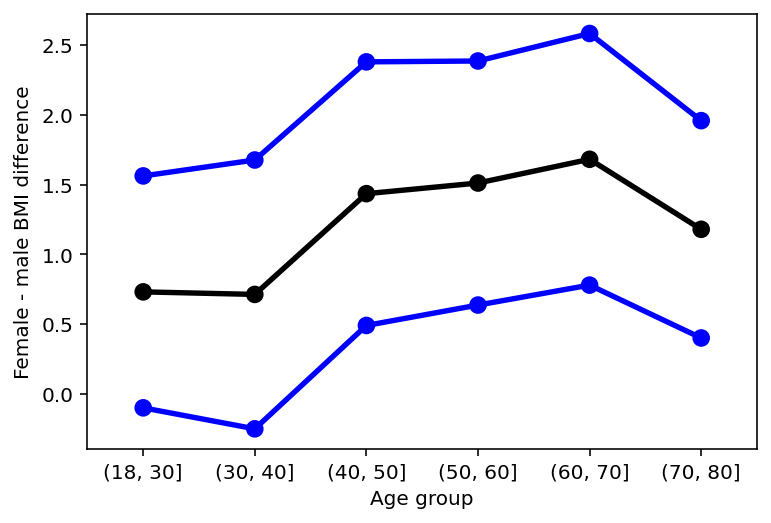

In [28]:
# calculate the mean, SD, and sample size for BMI within age/gender groups
df['agegrp'] = pd.cut(df.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
pr = df \
    .groupby(['agegrp', 'RIAGENDRx']) \
    .agg({'BMXBMI': [np.mean, np.std, np.size]}) \
    .unstack()

# calculate the SEM for females and for males within each age band
pr['BMXBMI', 'sem', 'Female'] = pr['BMXBMI', 'std', 'Female'] / np.sqrt(pr['BMXBMI', 'size', 'Female']) 
pr['BMXBMI', 'sem', 'Male'] = pr['BMXBMI', 'std', 'Male'] / np.sqrt(pr['BMXBMI', 'size', 'Male']) 

# calculate the mean difference of BMI between females and males within each age band, also  calculate
# its SE and the lower and upper limits of its 95% CI
pr['BMXBMI', 'mean_diff', ''] = pr['BMXBMI', 'mean', 'Female'] - pr['BMXBMI', 'mean', 'Male']
pr['BMXBMI', 'sem_diff', ''] = np.sqrt(pr['BMXBMI', 'sem', 'Female'] ** 2 + pr['BMXBMI', 'sem', 'Male'] ** 2) 
pr['BMXBMI', 'lcb_diff', ''] = pr['BMXBMI', 'mean_diff', ''] - 1.96 * pr['BMXBMI', 'sem_diff', ''] 
pr['BMXBMI', 'ucb_diff', ''] = pr['BMXBMI', 'mean_diff', ''] + 1.96 * pr['BMXBMI', 'sem_diff', ''] 

# plot the mean difference in black and the confidence limits in blue
x = np.arange(pr.shape[0])
pp = sns.pointplot(x, pr['BMXBMI', 'mean_diff', ''], color='black')
sns.pointplot(x, pr['BMXBMI', 'lcb_diff', ''], color='blue')
sns.pointplot(x, pr['BMXBMI', 'ucb_diff', ''], color='blue')

pp.set_xticklabels(pr.index)
pp.set_xlabel('Age group')
pp.set_ylabel('Female - male BMI difference');

**Inter-group and intra-group differences:** As the sample size grows, estimates become increasingly precise, but it is important to remember that a highly precise estimate for the mean does not imply that individuals within a population do not vary from each other.  To put the differences shown above in context, below we show the underlying summaries on which the plot above was based.  Note that the standard deviation of BMI within both females and males ranges from around 5 to around 8 depending on the age band.  This means, for example, that two randomly-selected males will tend to have BMI values that differ by around 6 units.  This is a far greater difference than the mean difference of up to around 1.5 BMI units between females and males.  Thus, while there is a tendency for females to have slightly higher BMI than males, the heterogeneity within genders is substantially greater than the difference of means between genders.

##### Confidence intervals and sample size

Confidence intervals reflect the precision of an estimate, which is largely driven by the amount of data used to construct the estimate.  We can explore the relationship between precision and sample size by subampling data from NHANES and calculating confidence intervals for the subsamples.  Below we calculate confidence intervals based on subsamples of size 100, 200, 400, and 800.

A wider confidence interval implies that we have less precision in our estimate.  In the simulation below, we calculate the average width of the confidence intervals constructed for each sample size.  We see that the confidence interval steadily becomes shorter as the sample size grows.  For most settings, the confidence interval will become around half as wide when the sample size is increased by a factor of 4.  Below we see this scaling when the sample size increases from 100 to 400, and when it increases from 200 to 800, both of which are increases by a factor of 4.

In [29]:
dx = df.loc[df.RIAGENDRx == 'Female', ['RIAGENDRx', 'BMXBMI']].dropna()

all_cis = []
for n in 100, 200, 400, 800:
    cis = []
    
    for i in range(500):
        dz = dx.sample(n)
        ci = sm.stats.DescrStatsW(dz.BMXBMI).zconfint_mean()
        cis.append(ci)
    
    cis = np.asarray(cis)
    mean_width = cis[:, 1].mean() - cis[:, 0].mean()
    
    print(n, mean_width)
    all_cis.append(cis)

100 3.046386477701411
200 2.1391359377946593
400 1.5186830707329158
800 1.0751063890699015


It is also informative to plot the individual confidence intervals, computed for 500 subsamples of size 100, to see how they vary.  The vertical grey bars below each correspond to a confidence interval.  The red horizontal line is the mean BMI calculated using the entire data set, which can be taken as a proxy for othe population mean.  While the individual intervals are quite different from each other, it appears that the vast majority of them cover the population value.

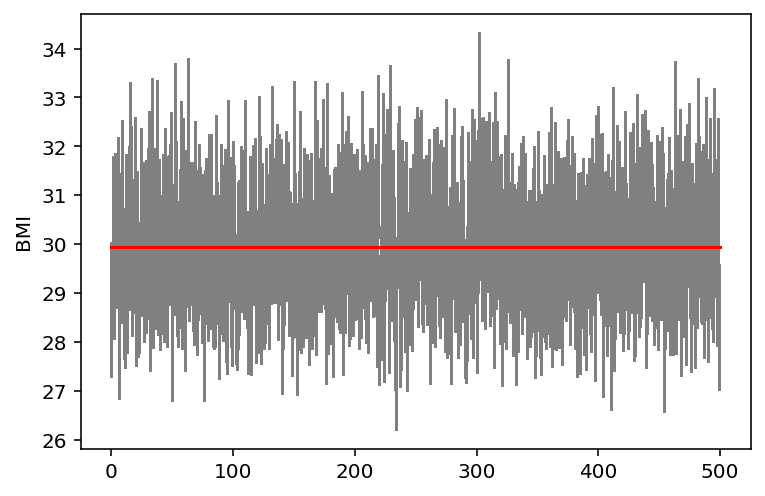

In [30]:
ci = all_cis[0]

for j, x in enumerate(ci):
    plt.plot([j, j], x, color='grey')
    plt.gca().set_ylabel('BMI')

mn = dx.BMXBMI.mean()
plt.plot([0, 500], [mn, mn], color='red');